In [1]:
import zipfile
import os
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans

from JicBitstream import JicBitstream, JicBitstreamZip
from knowledge import PU_ADDR
from knowledge2 import BLK_LOC_START_BIT

%matplotlib notebook

In [2]:
def compare(lst, fn0, fn1, path="../../results/out/", verbose=False):
    if verbose:
        print(f"comparing {os.path.basename(fn0)} and {os.path.basename(fn1)}")
    fn0 = os.path.join(path, fn0)
    fn1 = os.path.join(path, fn1)
    jic0 = JicBitstreamZip(fn0)
    jic1 = JicBitstreamZip(fn1)
    diff = jic0.diff_pos(jic1)
    if verbose:
        print(diff)
    lst.append(diff)

In [51]:
def is_checksum_blk(addr):
    diff = BLK_LOC_START_BIT - addr
    lo = 1 <= diff 
    hi = diff <= 16
    comb = lo * hi
    ret = np.any(comb)
    #print(addr, ret, diff)
    return ret

In [57]:
def offs_cor(addr):
    return addr - (np.sum(addr > BLK_LOC_START_BIT) * 64)

In [40]:
pin_list = open("../../resources/pin_list_5SGSMD5K1F40C1_8A.txt", "r").readlines()
pin_list = [pin.strip() for pin in pin_list]

In [65]:
IOSTD_ADDR = {}

UNKNW_BLK_LOWER_LIM = {}
UNKNW_BLK_UPPER_LIM = {}
UNKWN_BLK_NR = {}

In [115]:
for pin in pin_list: #["R32", "B32", "A32"]: # pin_list:
    print("\n", pin)
    diff_lst = []

    # IO std diff
    compare(diff_lst, f"{pin}_2V5_8mA_pu_off_dly_no.zip", f"{pin}_sstl15_default.zip")
    compare(diff_lst, f"{pin}_2V5_8mA_pu_off_dly_no.zip", f"{pin}_sstl15_class1_default.zip")
    compare(diff_lst, f"{pin}_2V5_8mA_pu_off_dly_no.zip", f"{pin}_sstl15_class2_default.zip")
    
    diff_lst_comb = []

    for diff in diff_lst:
        for el in diff[0]:
            if not is_checksum_blk(el):
                diff_lst_comb.append(offs_cor(el))

    diff_lst_comb = np.array(sorted(list(set(diff_lst_comb))))
    X = diff_lst_comb.reshape(-1, 1)

    kmeans = KMeans(n_clusters=3, random_state=123).fit(X)
    print("K-means cluster centers", kmeans.cluster_centers_.reshape(-1))

    APPROX_PIN_LOC = int(1e6)
    PIN_GROUP = kmeans.predict(np.array([APPROX_PIN_LOC]).reshape(1, -1))
    feat_addrs = X[kmeans.labels_ == PIN_GROUP].reshape((-1))
    

    rel_to_pu = feat_addrs - offs_cor(PU_ADDR[pin])
    print(feat_addrs)
    print(rel_to_pu)
    idx544 = np.where(rel_to_pu == 544)[0][0]
    print(rel_to_pu[idx544], rel_to_pu[idx544+1], (rel_to_pu[idx544+1] - 1504) / 1344)
    
    UNKNW_BLK_LOWER_LIM[pin] = feat_addrs[idx544]
    UNKNW_BLK_UPPER_LIM[pin] = feat_addrs[idx544+1]
    UNKWN_BLK_NR[pin] = (rel_to_pu[idx544+1] - 1504) // 1344

    print(feat_addrs[idx544-8:idx544+3])
    IOSTD_ADDR[pin] = feat_addrs[idx544-5:idx544+3]


 R32
K-means cluster centers [2.68427617e+08 1.15831700e+06 3.65100000e+03]
[1096583 1096839 1096999 1104583 1104903 1104935 1105095 1105383 1105543
 1158317 1158349 1158381 1158413 1158445 1158477 1158509 1158573 1158605
 1158669 1158701 1158733 1158765 1159373 1164365 1164397 1164461]
[-62246 -61990 -61830 -54246 -53926 -53894 -53734 -53446 -53286   -512
   -480   -448   -416   -384   -352   -320   -256   -224   -160   -128
    -96    -64    544   5536   5568   5632]
544 5536 3.0
[1158477 1158509 1158573 1158605 1158669 1158701 1158733 1158765 1159373
 1164365 1164397]

 P32
K-means cluster centers [1.16234900e+06 2.68427613e+08 3.65900000e+03]
[1096583 1096839 1096999 1104583 1104903 1104935 1105095 1105383 1105543
 1162349 1162381 1162413 1162445 1162477 1162509 1162541 1162605 1162637
 1162701 1162733 1162765 1162797 1163405 1164365 1164397 1164461]
[-66278 -66022 -65862 -58278 -57958 -57926 -57766 -57478 -57318   -512
   -480   -448   -416   -384   -352   -320   -256   -224   -1

K-means cluster centers [2.87100000e+03 2.68427617e+08 1.02922900e+06]
[1028845 1028877 1028909 1028941 1028973 1029005 1029037 1029101 1029133
 1029197 1029229 1029261 1029293 1029901 1032205 1032237 1032301 1096583
 1096839 1096999 1104583 1104903 1104935 1105095 1105383 1105543]
[ -512  -480  -448  -416  -384  -352  -320  -256  -224  -160  -128   -96
   -64   544  2848  2880  2944 67226 67482 67642 75226 75546 75578 75738
 76026 76186]
544 2848 1.0
[1029005 1029037 1029101 1029133 1029197 1029229 1029261 1029293 1029901
 1032205 1032237]

 E34
K-means cluster centers [2.80700000e+03 2.68427616e+08 9.75117000e+05]
[ 974701  974733  974765  974797  974829  974861  974893  974957  974989
  975053  975085  975117  975149  975757  980749  980781  980845 1096583
 1096839 1096999 1104583 1104903 1104935 1105095 1105383 1105543]
[  -512   -480   -448   -416   -384   -352   -320   -256   -224   -160
   -128    -96    -64    544   5536   5568   5632 121370 121626 121786
 129370 129690 129722 

K-means cluster centers [2.83900000e+03 2.68427618e+08 8.42573000e+05]
[ 842125  842157  842189  842221  842253  842285  842317  842381  842413
  842477  842509  842541  842573  843181  846829  846861  846925 1096583
 1096839 1096999 1104583 1104903 1104935 1105095 1105383 1105543]
[  -512   -480   -448   -416   -384   -352   -320   -256   -224   -160
   -128    -96    -64    544   4192   4224   4288 253946 254202 254362
 261946 262266 262298 262458 262746 262906]
544 4192 2.0
[842285 842317 842381 842413 842477 842509 842541 842573 843181 846829
 846861]

 J33
K-means cluster centers [2.83900000e+03 2.68427616e+08 8.43917000e+05]
[ 843469  843501  843533  843565  843597  843629  843661  843725  843757
  843821  843853  843885  843917  844525  846829  846861  846925 1096583
 1096839 1096999 1104583 1104903 1104935 1105095 1105383 1105543]
[  -512   -480   -448   -416   -384   -352   -320   -256   -224   -160
   -128    -96    -64    544   2848   2880   2944 252602 252858 253018
 260602

<IPython.core.display.Javascript object>


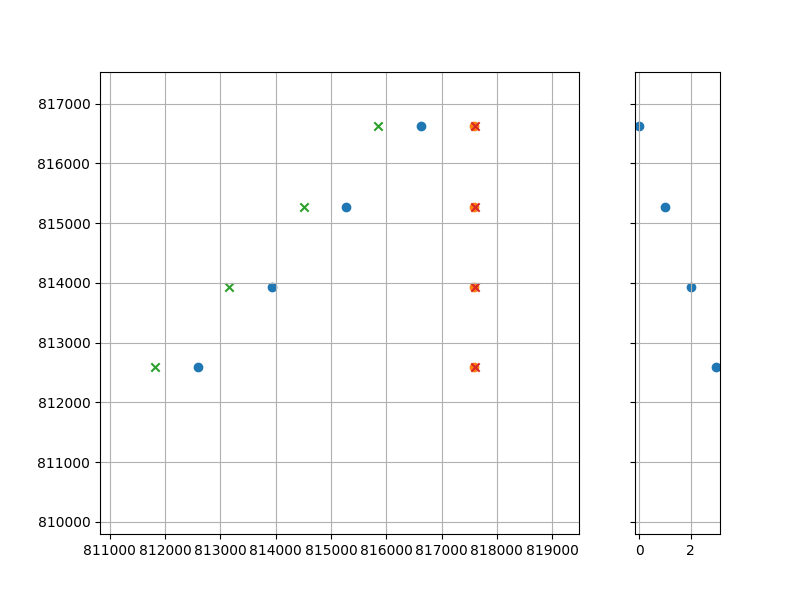

In [116]:
UNKNW_BLK_LOWER_LIM = dict(
    sorted(UNKNW_BLK_LOWER_LIM.items(), key=lambda item: item[1])
)
UNKNW_BLK_UPPER_LIM = dict(
    sorted(UNKNW_BLK_UPPER_LIM.items(), key=lambda item: item[1])
)

fig = plt.figure(figsize=(8, 6))
ax, ax2 = fig.subplots(1, 2, sharey=True, gridspec_kw={"width_ratios": [0.85, 0.15]})

ax.scatter(UNKNW_BLK_LOWER_LIM.values(), UNKNW_BLK_LOWER_LIM.values())
ax.scatter(UNKNW_BLK_UPPER_LIM.values(), UNKNW_BLK_LOWER_LIM.values())
ax.scatter(
    [IOSTD_ADDR[a][0] for a in UNKNW_BLK_LOWER_LIM],
    UNKNW_BLK_LOWER_LIM.values(),
    marker='x'
)
ax.scatter(
    [IOSTD_ADDR[a][-1] for a in UNKNW_BLK_LOWER_LIM],
    UNKNW_BLK_LOWER_LIM.values(),
    marker='x'
)
ax.grid(True)

ax2.scatter(
    [UNKWN_BLK_NR[a] for a in UNKNW_BLK_LOWER_LIM], UNKNW_BLK_LOWER_LIM.values()
)
ax2.grid(True)

In [101]:
x = np.array(list(UNKNW_BLK_LOWER_LIM.values()))
list(UNKNW_BLK_UPPER_LIM.values())[::4]

[817581, 846829, 898285, 951501, 980749, 1032205, 1083661, 1112909, 1164365]

In [44]:
print(PU_ADDR)
#print(CHKSUM_ADDR)

{'R32': 1162477, 'P32': 1166573, 'U31': 1163821, 'T31': 1165165, 'N32': 1110701, 'M32': 1114733, 'N33': 1112045, 'M33': 1113389, 'L33': 1081261, 'L34': 1085293, 'P34': 1082605, 'N34': 1083949, 'D33': 1029421, 'C33': 1033517, 'B32': 1030765, 'A32': 1032109, 'E34': 977645, 'D34': 981677, 'A34': 978989, 'A35': 980333, 'C34': 948205, 'B34': 952237, 'A36': 949549, 'A37': 950893, 'E32': 894605, 'F32': 898637, 'G33': 895949, 'G32': 897293, 'F33': 842829, 'E33': 846861, 'K33': 844173, 'J33': 845517, 'H34': 813325, 'G34': 817421, 'K34': 814733, 'J34': 816077, 'AU27': 764214, 'AT27': 762870, 'AW26': 765558, 'AV26': 761526, 'AU26': 712438, 'AT26': 711094, 'AR27': 713782, 'AP27': 709750, 'AM26': 682998, 'AL26': 681654, 'AN27': 684342, 'AN26': 680246, 'AE26': 1165141, 'AD26': 1163797, 'AA25': 1166549, 'AB25': 1162453, 'AC26': 1113365, 'AC25': 1112021, 'AK26': 1114709, 'AJ26': 1110677, 'AG26': 1083925, 'AF26': 1082581, 'AH25': 1085269, 'AG25': 1081237, 'AW25': 1030325, 'AV25': 1028981, 'AU25': 10316

In [7]:
factory = JicBitstream("../../bitstreams/decomp/factory_decompress0.jic")
#factory = JicBitstream("../../bitstreams/ddr3_ex/AH27_no_term.jic")
#factory = JicBitstream("../../bitstreams/ddr3_ex/default2.jic")
#factory = JicBitstream("../../bitstreams/ddr3_ex/AJ29_series_50_Ohm_no_calib.jic")
#factory = JicBitstream("../../bitstreams/ref/factory_trim18.jic")

for k, v in PU_ADDR.items():
    pu = factory.get_els([v])
    print(k, v, pu)

AU27 764214 [1]
AT27 762870 [1]
AW26 765558 [0]
AV26 761526 [0]
AU26 712438 [1]
AT26 711094 [1]
AR27 713782 [1]
AP27 709750 [1]
AM26 682998 [1]
AL26 681654 [1]
AN27 684342 [1]
AN26 680246 [1]
AE26 1165141 [1]
AD26 1163797 [1]
AA25 1166549 [1]
AB25 1162453 [1]
AC26 1113365 [1]
AC25 1112021 [1]
AK26 1114709 [1]
AJ26 1110677 [1]
AG26 1083925 [1]
AF26 1082581 [1]
AH25 1085269 [1]
AG25 1081237 [1]
AW25 1030325 [1]
AV25 1028981 [1]
AU25 1031669 [1]
AU24 1027637 [1]
AT24 978549 [1]
AR24 977205 [1]
AR25 979893 [1]
AP25 975861 [1]
AN25 949109 [1]
AM25 947765 [1]
AP24 950453 [1]
AN24 946357 [1]
AC24 897269 [1]
AB24 895925 [1]
AF25 898613 [1]
AE25 894581 [1]
AE24 845493 [1]
AD24 844149 [1]
AG24 846837 [1]
AH24 842805 [1]
AK24 816053 [1]
AJ24 814709 [1]
AL24 817397 [1]
AL25 813301 [1]
